<a href="https://colab.research.google.com/github/prtk2001/Crop-disease-Prediction/blob/main/Crop_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()
tf.compat.v1.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [ ]:
#file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'
#zip_file = tf.keras.utils.get_file(origin='https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn', 
#                                   fname='PlantVillage.zip', extract=True)
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip
#zip_file = tf.keras.utils.get_file(origin='https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn', 
 #                                  fname='PlantVillage.zip', extract=True)

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:09, 87.9MB/s]


In [ ]:
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
#data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
#train_dir = os.path.join(data_dir, 'train')
#validation_dir = os.path.join(data_dir, 'val')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(val_dir))


total images for training : ./PlantVillage/train : 44016files
total images for validation : ./PlantVillage/val : 11004files


In [ ]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
33dc8985c943175a7a1301fe034c01d69bebb8cf
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/jarRepositories.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/vcs.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor

In [ ]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
print('Number of classes:',len(classes))

Number of classes: 38


In [ ]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 

In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 11004 images belonging to 39 classes.
Found 44016 images belonging to 39 classes.


In [ ]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
                 
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [ ]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
687/687 [==============================] - 465s 673ms/step - loss: 0.7302 - accuracy: 0.7797 - val_loss: 0.3024 - val_accuracy: 0.9057
Epoch 2/10
687/687 [==============================] - 461s 670ms/step - loss: 0.4406 - accuracy: 0.8597 - val_loss: 0.2661 - val_accuracy: 0.9113
Epoch 3/10
687/687 [==============================] - 458s 666ms/step - loss: 0.3819 - accuracy: 0.8735 - val_loss: 0.2343 - val_accuracy: 0.9221
Epoch 4/10
687/687 [==============================] - 458s 667ms/step - loss: 0.3638 - accuracy: 0.8808 - val_loss: 0.2346 - val_accuracy: 0.9223
Epoch 5/10
687/687 [==============================] - 457s 665ms/step - loss: 0.3521 - accuracy: 0.8844 - val_loss: 0.1963 - val_accuracy: 0.9320
Epoch 6/10
687/687 [==============================] - 455s 662ms/step - loss: 0.3384 - accuracy: 0.8866 - val_loss: 0.2023 - val_accuracy: 0.9335
Epoch 7/10
687/687 [==============================] - 457s 665ms/step - loss: 0.3319 - accuracy: 0.8904 - val_loss: 0.1831 -

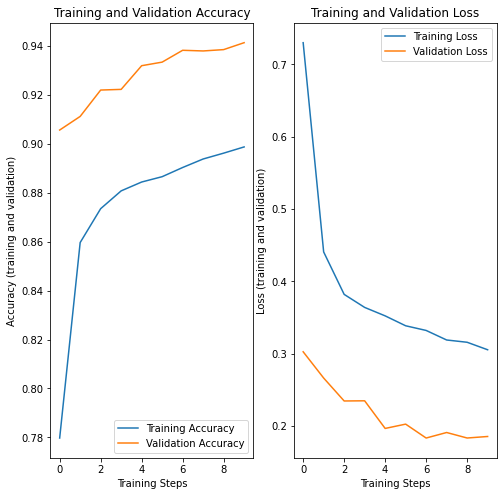

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(root_dir, val_dir, filename))
    assert not isinstance(img,type(None)), 'image not found'
    
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
  
    img = img /255
    
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

PREDICTED: class: Potato___Early_blight, confidence: 0.840220


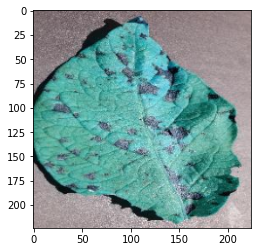

In [ ]:
#for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
#    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
img = load_image('/content/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')
prediction = predict(img)
print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
plt.imshow(img)
#plt.figure(idx)    
plt.show()


In [ ]:


tf.executing_eagerly()

True

In [ ]:
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

TF_LITE_MODEL_FILE_NAME = "crop_prediction.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpodpk_g2n/assets


INFO:tensorflow:Assets written to: /tmp/tmpodpk_g2n/assets


11633920